In [1]:
import matplotlib.pyplot as plt
import tifffile
import json
import re
from pathlib import Path
from perinuclear_analysis.image_loader import ImageLoader
from perinuclear_analysis.mip_creator import MIPCreator
from perinuclear_analysis.utils import create_channel_color_mapping, get_colormap_from_fluorophore



/Users/gabrielduarte/Documents/GitHub/SaezAtienzar/perinuclear_analysis/perinuclear_analysis/__init__.py:57: UserWarning: Phase 4 dependencies not installed: No module named 'perinuclear_analysis.ring_analysis'
Install with: pip install .[phase4]
  warnings.warn(
/Users/gabrielduarte/Documents/GitHub/SaezAtienzar/perinuclear_analysis/perinuclear_analysis/__init__.py:69: UserWarning: Phase 5 dependencies not installed: No module named 'perinuclear_analysis.signal_quantification'
Install with: pip install .[phase5]
  warnings.warn(


In [2]:
nd2_path = Path("/Users/gabrielduarte/Documents/GitHub/SaezAtienzar/perinuclear_analysis/data/ALIX/nd2/anti_ALIX_15_min_1.nd2")
mip_out = nd2_path.with_name(nd2_path.stem + "_mip.tiff")
mip_out

PosixPath('/Users/gabrielduarte/Documents/GitHub/SaezAtienzar/perinuclear_analysis/data/ALIX/nd2/anti_ALIX_15_min_1_mip.tiff')

In [3]:
loader = ImageLoader()
zstack = loader.load_image(nd2_path)
zstack.shape

2025-09-03 15:47:31,795 - perinuclear_analysis.image_loader - INFO - Converting anti_ALIX_15_min_1.nd2 to OME-TIFF format for pipeline compatibility
2025-09-03 15:47:31,796 - perinuclear_analysis.format_converter - INFO - Converting /Users/gabrielduarte/Documents/GitHub/SaezAtienzar/perinuclear_analysis/data/ALIX/nd2/anti_ALIX_15_min_1.nd2 to /Users/gabrielduarte/Documents/GitHub/SaezAtienzar/perinuclear_analysis/data/ALIX/nd2/anti_ALIX_15_min_1.ome.tiff
2025-09-03 15:47:31,839 - perinuclear_analysis.format_converter - INFO - Expected Z levels: 23, Channels: 4
2025-09-03 15:47:31,839 - perinuclear_analysis.format_converter - INFO - Reader axes: ['x', 'y', 'c', 't', 'z']
2025-09-03 15:47:31,840 - perinuclear_analysis.format_converter - INFO - Reader sizes: {'x': 1800, 'y': 1800, 'c': 4, 't': 1, 'z': 23}
2025-09-03 15:47:31,840 - perinuclear_analysis.format_converter - INFO - Available frames: 23
2025-09-03 15:47:31,892 - perinuclear_analysis.format_converter - INFO - Frame shape: (1800,

(23, 1800, 1800, 4)

In [4]:
zstack.dtype

dtype('uint16')

In [5]:
mip_creator = MIPCreator()
mip = mip_creator.create_mip(zstack, method="max")

mip_creator.save_mip_tiff(
    mip,
    mip_out,
    dtype="uint16",               # or 'auto'
    normalize=True,
    compress=6,
    metadata={"source": str(nd2_path), "projection": "max"},
    overwrite=True,
)

mip_out

2025-09-03 15:48:06,135 - perinuclear_analysis.mip_creator - INFO - Creating max projection from shape (23, 1800, 1800, 4)
2025-09-03 15:48:09,013 - perinuclear_analysis.mip_creator - INFO - Created max projection with shape (1800, 1800, 4)
2025-09-03 15:48:09,139 - perinuclear_analysis.mip_creator - INFO - Saved MIP to /Users/gabrielduarte/Documents/GitHub/SaezAtienzar/perinuclear_analysis/data/ALIX/nd2/anti_ALIX_15_min_1_mip.tiff (uint16, shape=(1800, 1800, 4))


PosixPath('/Users/gabrielduarte/Documents/GitHub/SaezAtienzar/perinuclear_analysis/data/ALIX/nd2/anti_ALIX_15_min_1_mip.tiff')

In [6]:
import numpy as np
import tifffile
import json
import re
from pathlib import Path

def inspect_ome_tiff(file_path):
    """Comprehensive inspection of OME-TIFF file."""
    
    file_path = Path(file_path)
    print(f"Inspecting: {file_path.name}")
    print(f"File size: {file_path.stat().st_size / 1e6:.2f} MB")
    print("=" * 60)

    with tifffile.TiffFile(file_path) as tif:
        print("BASIC STRUCTURE:")
        print(f"  Pages: {len(tif.pages)}")
        print(f"  Series: {len(tif.series)}")

        # Main series info
        series = tif.series[0]
        print(f"  Series shape: {series.shape}")
        print(f"  Series dtype: {series.dtype}")
        print(f"  Series axes: {series.axes}")

        # First page details
        page0 = tif.pages[0]
        print(f"  Page 0 shape: {page0.shape}")
        print(f"  Photometric: {page0.photometric}")
        print(f"  Compression: {page0.compression}")
        print()

        print("OME METADATA:")
        if hasattr(tif, 'ome_metadata') and tif.ome_metadata:
            print("  OME-XML found:")
            ome_xml = tif.ome_metadata
            print(f"  XML length: {len(ome_xml)} chars")

            # Look for channel info in XML
            if 'Channel' in ome_xml:
                channels = re.findall(r'<Channel.*?Name="([^"]*)"', ome_xml)
                print(f"  Channels from XML: {channels}")
        else:
            print("  No OME metadata found")

        # ImageJ metadata
        print("\nIMAGEJ METADATA:")
        if hasattr(tif, 'imagej_metadata') and tif.imagej_metadata:
            ij_meta = tif.imagej_metadata
            print(f"  ImageJ metadata: {ij_meta}")
        else:
            print("  No ImageJ metadata")

        # Description (JSON metadata)
        print("\nDESCRIPTION (JSON METADATA):")
        desc = page0.description
        if desc and desc.strip().startswith('{'):
            try:
                json_meta = json.loads(desc)
                print(f"  Channel names: {json_meta.get('channel_names', 'Not found')}")
                print(f"  Pixel size: {json_meta.get('pixel_size_um', 'Not found')} μm")
                print(f"  Dimensions: {json_meta.get('dimensions', 'Not found')}")
            except json.JSONDecodeError:
                print(f"  Description (first 200 chars): {desc[:200]}...")
        else:
            print(f"  Description: {desc}")

    # Load and inspect actual data
    print("\nDATA INSPECTION:")
    data = tifffile.imread(file_path)
    print(f"  Array shape: {data.shape}")
    print(f"  Array dtype: {data.dtype}")
    print(f"  Min/Max values: {data.min()} / {data.max()}")

    if data.ndim == 4:  # Z, Y, X, C
        print(f"  Z-slices: {data.shape[0]}")
        print(f"  Height: {data.shape[1]}")
        print(f"  Width: {data.shape[2]}")
        print(f"  Channels: {data.shape[3]}")

        print("\nPER-CHANNEL STATISTICS:")
        for c in range(data.shape[3]):
            channel_data = data[:, :, :, c]
            print(f"  Channel {c}: min={channel_data.min()}, max={channel_data.max()}, "
                  f"mean={channel_data.mean():.1f}, std={channel_data.std():.1f}")

            # Check if channel has any non-zero data
            nonzero_pixels = np.count_nonzero(channel_data)
            total_pixels = channel_data.size
            print(f"    Non-zero pixels: {nonzero_pixels}/{total_pixels} "
                  f"({100 * nonzero_pixels / total_pixels:.1f}%)")

    print("\n" + "=" * 60)

# Run the inspection
ome_file = Path("data/ALIX/nd2/anti_ALIX_15_min_1.ome.tiff")
if ome_file.exists():
    inspect_ome_tiff(ome_file)
else:
    print(f"File not found: {ome_file}")
    # List what files are actually there
    parent_dir = ome_file.parent
    print(f"Files in {parent_dir}:")
    for f in parent_dir.glob("*"):
        print(f"  {f.name}")

Inspecting: anti_ALIX_15_min_1.ome.tiff
File size: 367.80 MB
BASIC STRUCTURE:
  Pages: 23
  Series: 1
  Series shape: (23, 1800, 1800, 4)
  Series dtype: uint16
  Series axes: ZYXS
  Page 0 shape: (1800, 1800, 4)
  Photometric: 2
  Compression: 5

OME METADATA:
  OME-XML found:
  XML length: 778 chars
  Channels from XML: []

IMAGEJ METADATA:
  No ImageJ metadata

DESCRIPTION (JSON METADATA):
  Description: <?xml version="1.0" encoding="UTF-8"?><OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd" UUID="urn:uuid:d60dbcc2-88fe-11f0-87fa-7e67ded4de62" Creator="tifffile.py 2025.6.11"><Image ID="Image:0" Name="Image0"><Pixels ID="Pixels:0" DimensionOrder="XYCZT" Type="uint16" SizeX="1800" SizeY="1800" SizeC="4" SizeZ="23" SizeT="1" Interleaved="true" PhysicalSizeX="0.108333333333333" PhysicalSizeXUnit

In [7]:
mip_path = Path("data/ALIX/nd2/anti_ALIX_15_min_1_mip.tiff")
mip = tifffile.imread(mip_path)

json_path = Path("data/ALIX/nd2/anti_ALIX_15_min_1.ome.json")
with open(json_path) as f:
    metadata = json.load(f)
    
channel_names = metadata['channel_names']

print(f"MIP shape: {mip.shape}")

color_mapping = create_channel_color_mapping(channel_names)



MIP shape: (1800, 1800, 4)


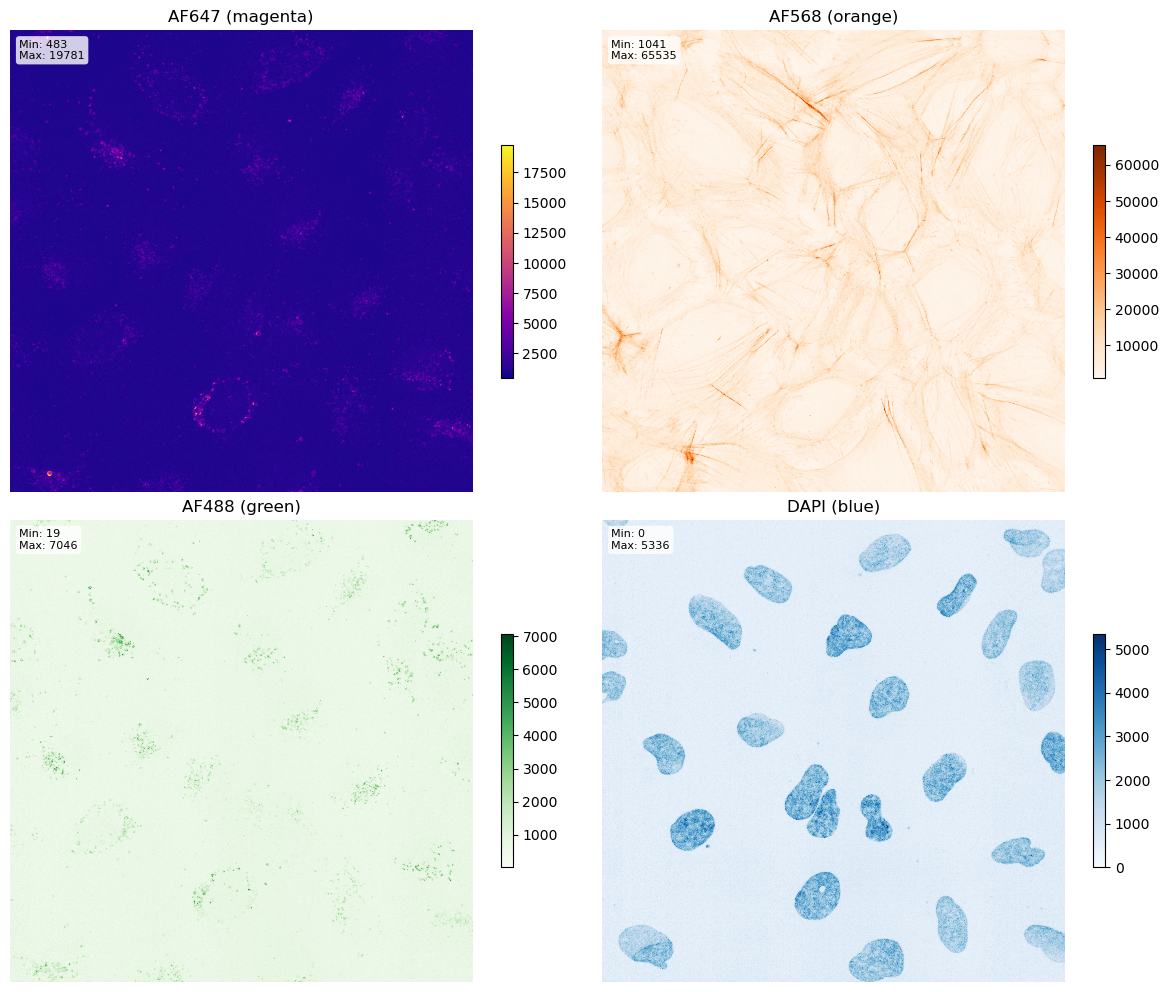

In [8]:
n_channels = mip.shape[-1]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(n_channels):
    ax = axes[i]
    channel_data = mip[:, :, i]
    
    colormap = get_colormap_from_fluorophore(channel_names[i])
    color_name = color_mapping[channel_names[i]]
    
    im = ax.imshow(channel_data, cmap=colormap,
                   interpolation='nearest')
    
    ax.set_title(channel_names[i] + f" ({color_name})", fontsize=12)
    ax.axis('off')
    
    plt.colorbar(im, ax=ax, shrink=0.5)
    
    ax.text(0.02, 0.98, f"Min: {channel_data.min()}\nMax: {channel_data.max()}",
            transform=ax.transAxes, fontsize=8,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none'))
            
            
plt.tight_layout()
plt.show()